In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../data/processed/realestates_kh_with_information_v2.csv')

In [3]:
df.shape

(3393, 19)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.shape

(3393, 19)

In [6]:
print("data")
print(df.head())

data
         id      price  bedrooms  bathrooms  land_area address_subdivision  \
0  185714.0  1100000.0       7.0        7.0      124.0          Phnom Penh   
1  185539.0   680000.0       4.0        5.0       80.0          Phnom Penh   
2  217752.0   550000.0       3.0        4.0       66.0          Phnom Penh   
3  228897.0   750000.0       9.0       10.0      116.0          Phnom Penh   
4  190024.0   420000.0       5.0        6.0       65.0          Phnom Penh   

  address_locality  address_line_2 category_name  is_parent         type  \
0        Daun Penh     Chakto Mukh     Shophouse      False  residential   
1       Chamkarmon           BKK 3         House      False  residential   
2        Daun Penh   Chey Chumneah       Retreat      False  residential   
3       Chamkarmon    Tonle Bassac         Villa      False  residential   
4   Chroy Changvar  Chroy Changvar         House      False  residential   

   latitude   longitude                    geometry  index_right  pop

In [28]:
df['price_per_m2'] = df['price_display'] / df['land_area']

In [29]:
df.to_csv('../../data/processed/realestates_kh_v4.csv', index=False)

In [7]:
import matplotlib.pyplot as plt


In [8]:
import folium
from folium.plugins import MarkerCluster

# Center map on Phnom Penh (or your area of interest)
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Normalize price_per_m2 for color scaling
import matplotlib
norm = matplotlib.colors.Normalize(vmin=df['price_per_m2'].min(), vmax=df['price_per_m2'].max())
cmap = matplotlib.cm.get_cmap('viridis')

# Add points to map
for _, row in df.iterrows():
    color = matplotlib.colors.rgb2hex(cmap(norm(row['price_per_m2'])))
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Price/m²: {row['price_per_m2']:.2f}"
    ).add_to(m)

m.save('realestate_price_map.html')

C:\Users\User\AppData\Local\Temp\ipykernel_21104\1498732564.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


In [16]:
# Calculate IQR for price_per_m2
Q1 = df['price_per_m2'].quantile(0.25)
Q3 = df['price_per_m2'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df[(df['price_per_m2'] < lower_bound) | (df['price_per_m2'] > upper_bound)]
print("Number of outliers:", len(outliers))
print(outliers[['price_per_m2', 'latitude', 'longitude']].head())
import folium

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

for _, row in df.iterrows():
    is_outlier = (row['price_per_m2'] < lower_bound) or (row['price_per_m2'] > upper_bound)
    color = 'red' if is_outlier else 'blue'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5 if is_outlier else 3,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7 if is_outlier else 0.3,
        popup=(
            f"Price/m²: {row['price_per_m2']:.2f}<br>"
            f"Land area: {row['land_area']}<br>"
            f"Type: {row['type']}<br>"
            f"Category: {row['category_name']}<br>"
            f"Price: {row['price']}"
        )
    ).add_to(m)

# Save to HTML
m.save('realestate_price_map_with_outliers.html')

Number of outliers: 123
   price_per_m2  latitude   longitude
0   8870.967742  11.57561  104.920250
1   8500.000000  11.55000  104.930000
2   8333.333333  11.57561  104.920250
3   6465.517241  11.54450  104.913586
4   6461.538462  11.58000  104.930000


In [17]:
# Show the number of listings in each category
category_counts = df['category_name'].value_counts()
print(category_counts)

category_name
Condo                  669
Villa                  566
House                  398
Shophouse              337
Land/Development       324
Flat                   235
Twin Villa             201
Apartment              160
Retreat                135
Unit                   105
Land                    53
Warehouse               46
other                   41
Studio                  33
Offices                 20
Terrace                 17
Business                12
project                  9
Penthouse                7
condo                    5
CommercialShophouse      4
Food/Hospitality         4
Retail                   3
Hotel                    3
Factory                  3
ServicedApartment        2
residential              1
Name: count, dtype: int64


In [18]:
category_counts_df = df['category_name'].value_counts().reset_index()
category_counts_df.columns = ['category_name', 'count']
print(category_counts_df)

          category_name  count
0                 Condo    669
1                 Villa    566
2                 House    398
3             Shophouse    337
4      Land/Development    324
5                  Flat    235
6            Twin Villa    201
7             Apartment    160
8               Retreat    135
9                  Unit    105
10                 Land     53
11            Warehouse     46
12                other     41
13               Studio     33
14              Offices     20
15              Terrace     17
16             Business     12
17              project      9
18            Penthouse      7
19                condo      5
20  CommercialShophouse      4
21     Food/Hospitality      4
22               Retail      3
23                Hotel      3
24              Factory      3
25    ServicedApartment      2
26          residential      1


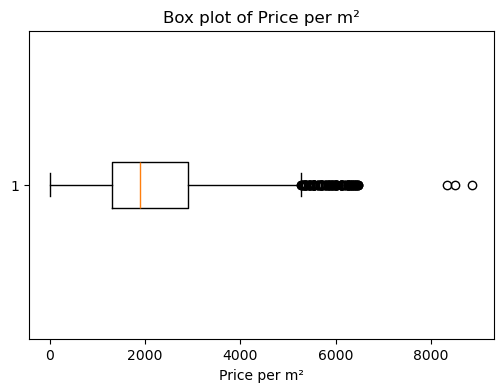

In [10]:
# Box plot
plt.figure(figsize=(6, 4))
plt.boxplot(df['price_per_m2'].dropna(), vert=False)
plt.title('Box plot of Price per m²')
plt.xlabel('Price per m²')
plt.show()


In [22]:
df.sort_values(by='price', ascending=False)

,id,price,bedrooms,bathrooms,land_area,address_subdivision,address_locality,address_line_2,category_name,is_parent,type,latitude,longitude,geometry,index_right,population,price_per_m2,information,price_display
171,235239.0,276264450.0,NaN,NaN,55811.0,Phnom Penh,Daun Penh,Srah Chak,Land/Development,False,residential,11.579202,104.908613,POINT (104.9086133 11.57920232),53926.0,9274.0,4950.0,Land in front of Eden Garden for Sales Size: 5...,"$276,264,450"
1829,248374.0,188343000.0,NaN,NaN,104635.0,Phnom Penh,Russey Keo,Tuol Sangkae 1,Land/Development,False,residential,11.587810,104.902234,POINT (104.9022337 11.5878099),54093.0,8037.0,1800.0,"Land Located at Tuol Kok Village, Sangkat Tuol...","$1,800.0/m²"
3074,248290.0,58800000.0,NaN,NaN,84000.0,Phnom Penh,Por Sen Chey,Kantaok,Land/Development,False,residential,11.537783,104.920232,POINT (104.920232 11.537783),53912.0,18375.0,700.0,Land for Sale or Rent on Road N3 Main Road - H...,$700.0/m²
335,163525.0,40500000.0,NaN,NaN,10000.0,Phnom Penh,Prek Pnov,Preaek Pnov,Land/Development,False,residential,11.624955,104.817840,POINT (104.81784 11.624955),53773.0,86.0,4050.0,"Location : Khan preak prov Sale Price: $4,050/...","$40,500,000"
3025,245244.0,40000000.0,NaN,NaN,50000.0,Phnom Penh,Sen Sok,Kouk Khleang,Land/Development,False,residential,11.578675,104.852651,POINT (104.8526513 11.57867513),53574.0,5234.0,800.0,"50,000m2 sale land: Land in Lake Lake Market ?...","$40,000,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,186059.0,4488.0,1.0,1.0,68.0,Phnom Penh,Daun Penh,Phsar Chas,Condo,False,residential,11.575610,104.920250,POINT (104.92025 11.57561),53920.0,16252.0,66.0,Luxury Condominium for Sale at Riverside Phnom...,$66/m²
1130,176147.0,2500.0,1.0,1.0,1.0,Phnom Penh,Chamkarmon,BKK 1,Condo,False,residential,11.550000,104.930000,POINT (104.93 11.55),53894.0,7658.0,2500.0,Location close to Russiean market - new buildi...,"$2,500.0/m²"
3300,233615.0,507.0,NaN,NaN,2.6,Phnom Penh,Dangkao,Prey Sa,Land/Development,False,residential,11.500658,104.856173,POINT (104.856173 11.500658),54676.0,2310.0,195.0,Corner investment land for sale at Prey Sar ar...,$195/m²
3295,231442.0,200.0,NaN,NaN,1.0,Phnom Penh,Por Sen Chey,Kakap,Land/Development,False,residential,11.544500,104.913586,POINT (104.913586 11.5445),53909.0,23239.0,200.0,Land for development for sale urgently | Inves...,$200/m²


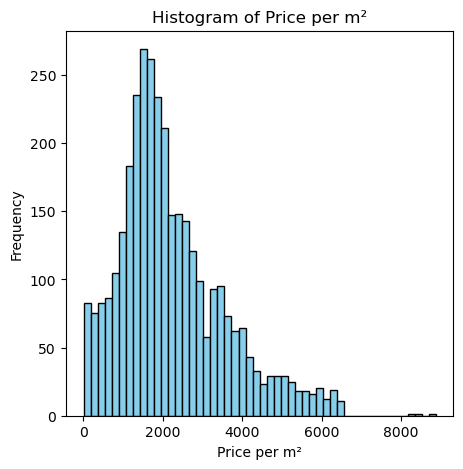

In [11]:
# Histogram
plt.figure(figsize=(5, 5))
plt.hist(df['price_per_m2'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Price per m²')
plt.xlabel('Price per m²')
plt.ylabel('Frequency')
plt.show()

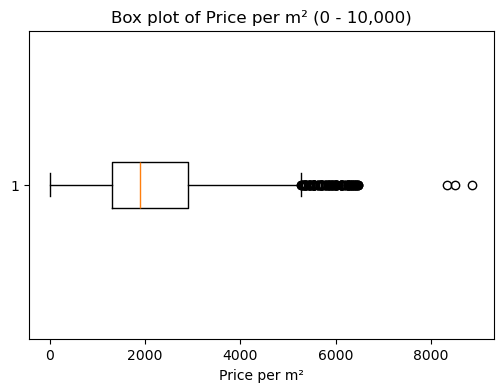

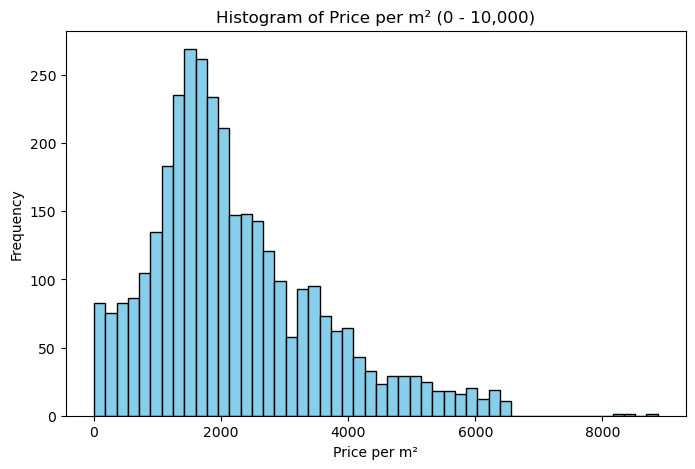

In [12]:
# Filter data for price_per_m2 between 0 and 10,000
df_filtered = df[(df['price_per_m2'] > 0) & (df['price_per_m2'] <= 100000)]

# Box plot
plt.figure(figsize=(6, 4))
plt.boxplot(df_filtered['price_per_m2'].dropna(), vert=False)
plt.title('Box plot of Price per m² (0 - 10,000)')
plt.xlabel('Price per m²')
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(df_filtered['price_per_m2'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Price per m² (0 - 10,000)')
plt.xlabel('Price per m²')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Calculate IQR for filtered data
Q1 = df_filtered['price_per_m2'].quantile(0.25)
Q3 = df_filtered['price_per_m2'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers in filtered data
outliers_filtered = df_filtered[(df_filtered['price_per_m2'] < lower_bound) | (df_filtered['price_per_m2'] > upper_bound)]

# Count outliers
print("Number of outliers in filtered data:", len(outliers_filtered))

# List all outliers with id and price_per_m2
print(outliers_filtered[['id', 'price_per_m2']])

Number of outliers in filtered data: 123
           id  price_per_m2
0    185714.0   8870.967742
1    185539.0   8500.000000
2    217752.0   8333.333333
3    228897.0   6465.517241
4    190024.0   6461.538462
..        ...           ...
118  212595.0   5312.500000
119  212651.0   5312.500000
120  143405.0   5300.000000
121  182640.0   5283.018868
122  182928.0   5283.018868

[123 rows x 2 columns]


In [14]:
outliers_filtered[['id', 'price_per_m2']]

,id,price_per_m2
0,185714.0,8870.967742
1,185539.0,8500.000000
2,217752.0,8333.333333
3,228897.0,6465.517241
4,190024.0,6461.538462
...,...,...
118,212595.0,5312.500000
119,212651.0,5312.500000
120,143405.0,5300.000000
121,182640.0,5283.018868


In [19]:
df_zero = pd.read_csv('../../data/processed/realestates_kh_price_per_m2_zero.csv')

In [20]:
category_counts_df = df_zero['category_name'].value_counts().reset_index()
category_counts_df.columns = ['category_name', 'count']
print(category_counts_df)

            category_name  count
0                   other     73
1               Shophouse     73
2                   Villa     55
3                   House     45
4                 Retreat     21
5        Land/Development     17
6                    Flat     15
7               Apartment      9
8                   Hotel      8
9                   Condo      8
10                   Land      5
11             Twin Villa      5
12                Offices      3
13                 Retail      1
14                   Unit      1
15              Warehouse      1
16  Leisure/Entertainment      1
17      ServicedApartment      1
